In [10]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


for i in range(32,33):
    soap = np.load(f"./temdata/soap/soap_features_w{i}.npy")
    n_structures = soap.shape[0]
    n_features = soap.shape[1]
    n_select = 100
    kmeans = KMeans(n_clusters=n_select, random_state=42, n_init=10)
    labels = kmeans.fit_predict(soap)
    selected_indices = []
    for cluster_id in range(n_select):
        cluster_mask = (labels == cluster_id)
        cluster_indices = np.where(cluster_mask)[0]

        if len(cluster_indices) == 0:
            continue

        cluster_structures = soap[cluster_mask]
        center = kmeans.cluster_centers_[cluster_id]
        distances = np.linalg.norm(cluster_structures - center, axis=1)
        closest_idx = cluster_indices[np.argmin(distances)]
        selected_indices.append(closest_idx)
    cluster_indices = np.array(selected_indices)
    rng = np.random.default_rng(42)
    random_indices = rng.choice(n_structures, size=n_select, replace=False)


   方法           Coverage     Diversity   
   ----------------------------------------
   Clustering   0.2715       0.8653      
   Random       0.2934       0.7868      
   Improvement          7.5%        10.0%

5. 生成可视化...
   保存图片: clustering_demo.png

总结
✅ 聚类方法比随机采样:
   - Coverage 改进: +7.5%
   - Diversity 改进: +10.0%

观察可视化图:
   - 左图（聚类）: 红点分布应该更均匀
   - 右图（随机）: 蓝点可能聚集在某些区域


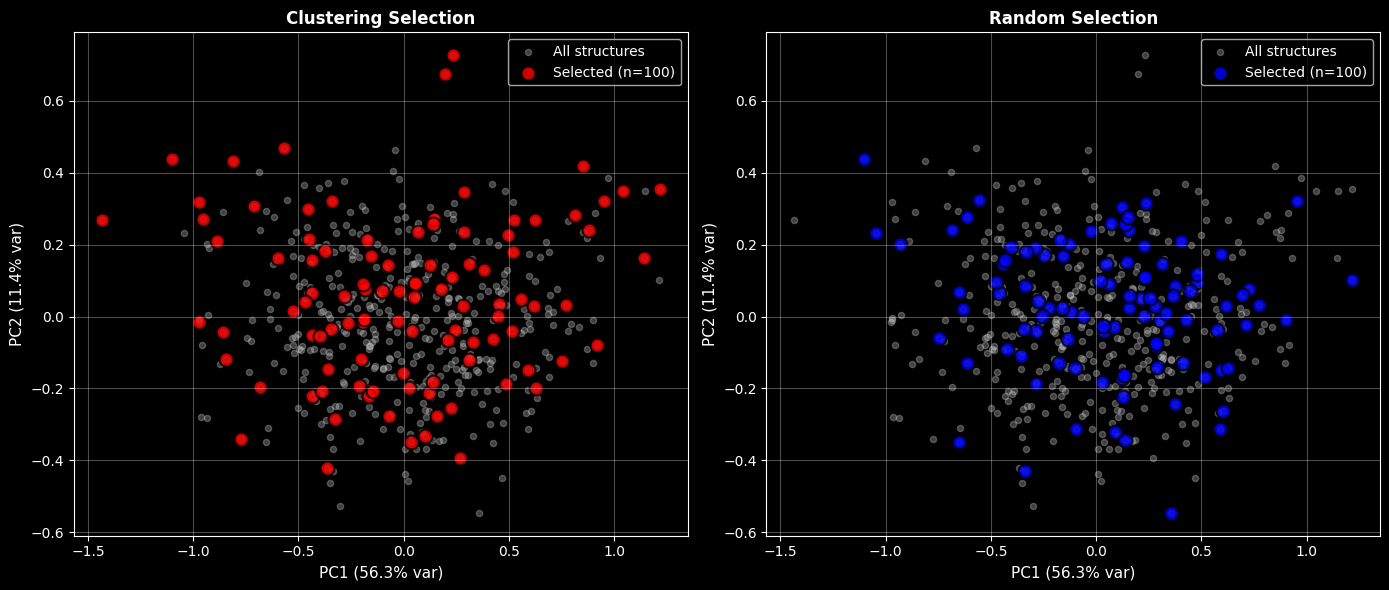

In [11]:

soap_features = soap
def compute_metrics(features, selected):
    selected_features = features[selected]

    # Coverage
    distances = pairwise_distances(features, selected_features)
    coverage = distances.min(axis=1).mean()

    # Diversity
    if len(selected_features) > 1:
        selected_distances = pairwise_distances(selected_features)
        mask = np.triu(np.ones(selected_distances.shape), k=1).astype(bool)
        diversity = selected_distances[mask].mean()
    else:
        diversity = 0.0

    return coverage, diversity

cov_cluster, div_cluster = compute_metrics(soap_features, cluster_indices)
cov_random, div_random = compute_metrics(soap_features, random_indices)

print(f"\n   {'方法':<12} {'Coverage':<12} {'Diversity':<12}")
print(f"   {'-'*40}")
print(f"   {'Clustering':<12} {cov_cluster:<12.4f} {div_cluster:<12.4f}")
print(f"   {'Random':<12} {cov_random:<12.4f} {div_random:<12.4f}")

cov_imp = (cov_random - cov_cluster) / cov_random * 100
div_imp = (div_cluster - div_random) / div_random * 100

print(f"   {'Improvement':<12} {cov_imp:>11.1f}% {div_imp:>11.1f}%")

# ========== 5. 可视化 ==========
print("\n5. 生成可视化...")

# PCA降维
pca = PCA(n_components=2, random_state=42)
soap_2d = pca.fit_transform(soap_features)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 聚类选择
ax = axes[0]
ax.scatter(soap_2d[:, 0], soap_2d[:, 1], c='lightgray', s=20, alpha=0.3, label='All structures')
ax.scatter(soap_2d[cluster_indices, 0], soap_2d[cluster_indices, 1],
           c='red', s=100, alpha=0.8, edgecolors='black', linewidths=1.5,
           label=f'Selected (n={len(cluster_indices)})')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)', fontsize=11)
ax.set_title('Clustering Selection', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 随机选择
ax = axes[1]
ax.scatter(soap_2d[:, 0], soap_2d[:, 1], c='lightgray', s=20, alpha=0.3, label='All structures')
ax.scatter(soap_2d[random_indices, 0], soap_2d[random_indices, 1],
           c='blue', s=100, alpha=0.8, edgecolors='black', linewidths=1.5,
           label=f'Selected (n={len(random_indices)})')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)', fontsize=11)
ax.set_title('Random Selection', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('clustering_demo.png', dpi=150)
print("   保存图片: clustering_demo.png")

# ========== 6. 总结 ==========
print("\n" + "=" * 70)
print("总结")
print("=" * 70)
print(f"✅ 聚类方法比随机采样:")
print(f"   - Coverage 改进: {cov_imp:+.1f}%")
print(f"   - Diversity 改进: {div_imp:+.1f}%")
print(f"\n观察可视化图:")
print(f"   - 左图（聚类）: 红点分布应该更均匀")
print(f"   - 右图（随机）: 蓝点可能聚集在某些区域")
print("=" * 70)